In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk import word_tokenize
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# PROBLEM 1: Recommender System using Collaborative Filtering

In [ ]:
data = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
data = data.drop('timestamp', axis=1)

In [ ]:
data.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   100000 non-null  int64
 1   movie_id  100000 non-null  int64
 2   rating    100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [ ]:
# user-item ratings
ratings = pd.pivot_table(data, values ='rating', index ='user_id', columns ='movie_id')

# Computing cosine similarity between users
user_similarities = cosine_similarity(ratings.fillna(0))

In [ ]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)

In [ ]:
def predict(user_id, movie_id, user_similarities, ratings):
    
   
    rated_users = ratings[movie_id].dropna().index.values

    n_users = user_similarities.shape[0]
    user_similarities = np.vstack([user_similarities, np.zeros(n_users)])
    user_similarities = np.hstack([user_similarities, np.zeros((n_users + 1, 1))])
    
    #similarities between given user and rated users
    similarities = user_similarities[user_id][rated_users]
    
    ratings = ratings.loc[rated_users, movie_id]
    
    # Computing weighted average rating
    if len(ratings) > 0:
        weighted_ratings = np.dot(similarities, ratings) / similarities.sum()
    else:
        weighted_ratings = 0
    
    return weighted_ratings

In [ ]:
# Making rating predictions on the test set

test_data['predicted_rating'] = test_data.apply(lambda x: predict(x['user_id'], x['movie_id'], user_similarities, ratings), axis = 1)

In [ ]:
train_mean_rating = train_data['rating'].mean()
test_data['predicted_rating'] = test_data['predicted_rating'].fillna(train_mean_rating)

In [ ]:
test_data

,user_id,movie_id,rating,predicted_rating
75721,877,381,4,3.658704
80184,815,602,3,3.695451
19864,94,431,4,3.522430
76699,416,875,2,2.763837
92991,500,182,2,3.922957
...,...,...,...,...
32595,72,591,5,3.705931
29313,523,393,5,3.385565
37862,606,287,4,3.676455
53421,650,612,4,3.892241


In [ ]:
# Computing RMSE

rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print('RMSE on test set:', rmse)

RMSE on test set: 0.9384979637343117


# PROBLEM 3A: Social Community Detection

In [1]:
def calculate_betweenness_centrality(adj_list):

    # initialize betweenness centrality for all vertices to 0
    betweenness = {v: 0.0 for v in adj_list}

    # iterating over all pairs of vertices and find the shortest path between them
    for source in adj_list:
        dist = {v: None for v in adj_list}
        dist[source] = 0
        queue = [source]
        paths = {v: [] for v in adj_list}
        num_paths = {v: 0 for v in adj_list}
        num_paths[source] = 1

        while queue:
            vertex = queue.pop(0)
            for neighbor in adj_list[vertex]:
                if dist[neighbor] is None:
                    dist[neighbor] = dist[vertex] + 1
                    queue.append(neighbor)
                if dist[neighbor] == dist[vertex] + 1:
                    num_paths[neighbor] += num_paths[vertex]
                    paths[neighbor].append(vertex)

        # calculating betweenness centrality for each vertex as the sum of the fraction of shortest paths that pass through it
        dependencies = {v: 0.0 for v in adj_list}
        while paths:
            target, parents = paths.popitem()
            if parents:
                for parent in parents:
                    dependencies[parent] += (num_paths[parent] / num_paths[target]) * (1 + dependencies[target])
                    if target != source:
                        betweenness[target] += dependencies[target]

    # normalizing betweenness centrality by dividing by the number of possible pairs of vertices
    num_pairs = (len(adj_list) * (len(adj_list) - 1)) / 2
    for v in betweenness:
        betweenness[v] /= num_pairs

    return betweenness

In [4]:
# load the graph from the csv file as an adjacency list

edges_df = pd.read_csv('edges_sampled_2K.csv')
adj_list = {}
for row in edges_df.itertuples(index=False):
    u, v = row
    if u not in adj_list:
        adj_list[u] = []
    adj_list[u].append(v)
    if v not in adj_list:
        adj_list[v] = []
    adj_list[v].append(u)

# initialize the number of communities to be 1
num_communities = 1

# performing edge removal based on betweenness centrality until the graph is partitioned into the desired number of communities
while True:

    # calculating the betweenness centrality of all edges
    betweenness = calculate_betweenness_centrality(adj_list)

    # finding the edge(s) with the highest betweenness centrality
    max_betweenness = max(betweenness.values())
    edge_indices = [i for i, e in enumerate(betweenness.values()) if e == max_betweenness]

    # removing the edge(s) with the highest betweenness centrality
    for u, v in list(adj_list.items()):
        adj_list[u] = [x for x in v if x not in edge_indices]
    adj_list = {u: v for u, v in adj_list.items() if v}

    # checking if the graph is partitioned into the desired number of communities
    if len(list(adj_list.values())) == num_communities:
        break

    # incrementing the number of communities and continue edge removal
    num_communities += 1

# printing the number of communities
communities = list(adj_list.values())
for i, community in enumerate(communities):
    print(f'Community {i + 1}: {community}')

Community 1: [29697, 28142, 32909, 39063, 29151, 32939, 29097, 27340, 281, 19289, 8719, 26641, 20795, 9227, 26880, 26540, 27138, 19257, 26435, 26602, 26536]
Community 2: [27228, 29134, 44629, 33754, 30141, 33439, 33346, 5868, 6577, 11348, 18839, 6267, 10633, 26638, 26592, 22388, 16931, 26871, 29661, 29097, 26511, 26540, 19257, 26581, 27219, 23753, 23221, 26435, 4396, 29151, 26661]
Community 3: [27228, 27193, 26638, 26641, 27129, 16931, 27344, 26540, 26472, 26581, 27219, 25444, 37616, 36278, 29656, 29706, 29182, 26602]
Community 4: [27228, 26663, 23753]
Community 5: [27228, 26641, 3403, 26663, 26512, 34345, 29656]
Community 6: [27228, 10633, 2327, 8719, 26641, 11297, 16931, 27344, 26540, 27175, 26736, 26581, 27219, 25444, 23612, 76146, 29988, 29661, 29697, 33400, 38618, 30009, 29971, 32939, 30840]
Community 7: [27228, 281, 8719, 34319, 30826, 25444, 29151, 26602]
Community 8: [27228, 281, 18839, 6267, 19289, 27193, 14871, 10633, 26579, 8719, 13292, 27122, 26641, 9227, 14083, 33439, 3008

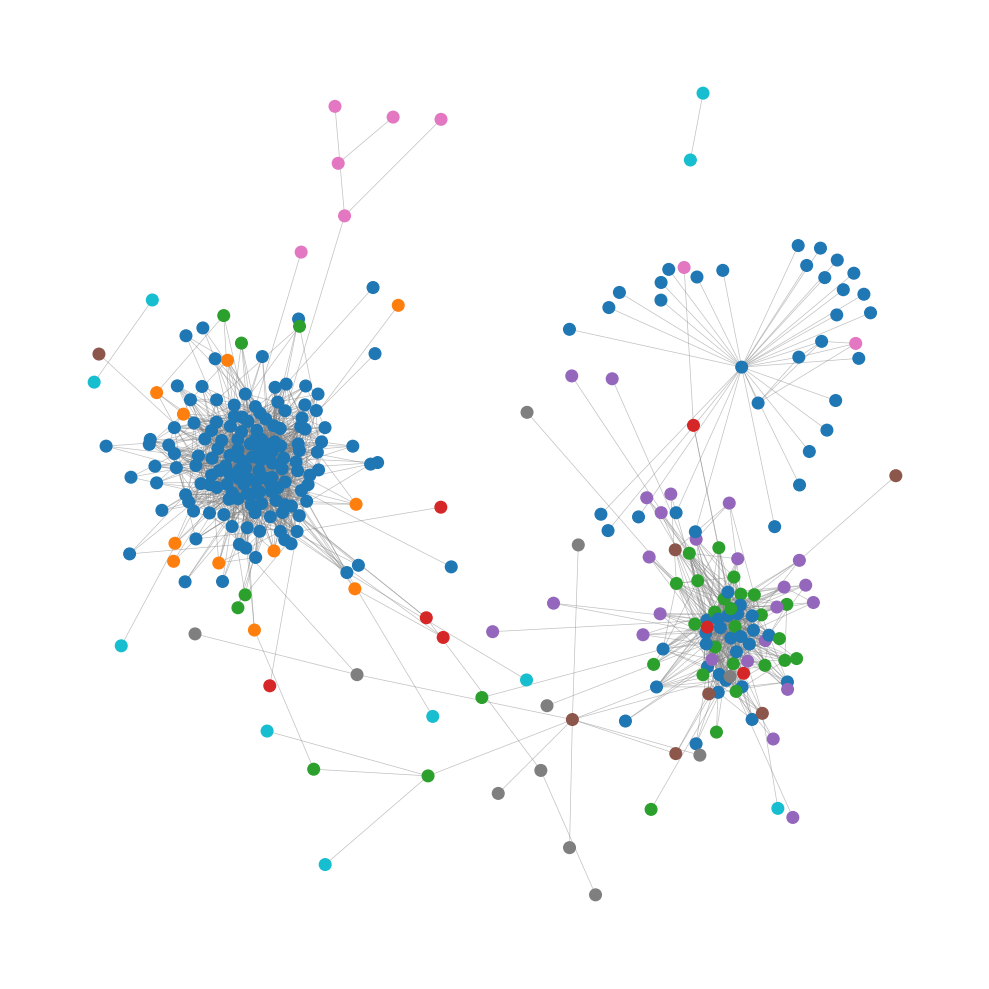

In [8]:
G = nx.Graph(adj_list)

# setting node colors based on community membership
colors = []
for node in G.nodes():
    for i, community in enumerate(communities):
        if node in community:
            colors.append(i+1)
            break

# plotting the graph with node colors based on community membership
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.2, seed=42) # adjust k to spread out or pull in the nodes
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab10, node_size =70, node_shape='o')
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray', width=0.5)
nx.draw_networkx_labels(G, pos, labels={}, font_size=10, font_family='sans-serif', font_weight='bold', alpha=0.8)
plt.axis('off')
plt.tight_layout()
plt.show()

# PROBLEM 4: Knowledge Base Question Answering

In [ ]:
# Function to get the cosine similarity between a relation and query

word2vec_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/word2vec_train_dev.dat.txt')
def get_rel_score_word2vecbase(rel, query):
    if rel not in word2vec_model.wv:
        return 0.0
    words = word_tokenize(query.lower())
    w_embs = []
    for w in words:
        if w in word2vec_model.wv:
            w_embs.append(word2vec_model.wv[w])
    return np.mean(cosine_similarity(w_embs, [word2vec_model.wv[rel]]))

In [ ]:
# Function to load the graph from file
def load_graph():
    # Preparing the graph
    graph = defaultdict(list)
    for line in open('/content/drive/MyDrive/graph.txt'):
        line = eval(line[:-1])
        graph[line[0]].append([line[1], line[2]])
    return graph

In [ ]:
KnowledgeGraph = load_graph()
KnowledgeGraph

defaultdict(list,
            {'m.01_d4': [['location.citytown.postal_codes', 'm.07nqmhw'],
              ['location.citytown.postal_codes', 'm.07nqmhf'],
              ['location.citytown.postal_codes', 'm.01_6pxw'],
              ['location.location.contains', 'm.021czc'],
              ['location.citytown.postal_codes', 'm.07nqmj9'],
              ['travel.travel_destination.tourist_attractions', 'm.02vv_6w'],
              ['location.citytown.postal_codes', 'm.01_71cx'],
              ['location.citytown.postal_codes', 'm.07nqmfx'],
              ['location.citytown.postal_codes', 'm.01_6y3n'],
              ['location.citytown.postal_codes', 'm.07nqmj2'],
              ['location.citytown.postal_codes', 'm.01_6p6k'],
              ['location.citytown.postal_codes', 'm.0gs227r'],
              ['location.citytown.postal_codes', 'm.01_6s_6'],
              ['travel.travel_destination.tourist_attractions', 'm.02rvwrv'],
              ['location.location.contains', 'm.01ky66'],
      

In [ ]:
# Function to load the queries from file
# Preparing the queries
def load_queries():
    queries = []
    for line in open('/content/drive/MyDrive/annotations.txt'):
        line = eval(line[:-1])
        queries.append(line)
    return queries

In [ ]:
queries = load_queries()
queries

[[1,
  'what time zones are there in the us',
  'm.09c7w0',
  [['ns:m.09c7w0', 'ns:location.location.time_zones', '?x']],
  'United States of America',
  [{'AnswerType': 'Entity',
    'AnswerArgument': 'm.027wj2_',
    'EntityName': 'Samoa Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.027wjl3',
    'EntityName': 'Chamorro Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02fqwt',
    'EntityName': 'Central Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02hcv8',
    'EntityName': 'Eastern Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02hczc',
    'EntityName': 'Mountain Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02lcqs',
    'EntityName': 'Pacific Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02lcrv',
    'EntityName': 'Alaska Time Zone'},
   {'AnswerType': 'Entity',
    'AnswerArgument': 'm.02lctm',
    'EntityName': 'Hawaii-Aleutian Time Zone'},
   {'AnswerType': 'Enti

In [ ]:
threshold = 0.3
results = []

for i in range(len(queries)):
    
    #Get Current Query, answer entities and starting node
    curr_query_question = queries[i][1]
    starting_node = queries[i][2]
    
    
    #Initialize lists to hold queues and predicted answers
    predicted_answers = []
    queue = []
    visited_nodes = []
    
    #Enqueue the current node to the queue
    visited_nodes.append(starting_node)
    queue.append(starting_node)
       
    #Running till queue is not empty
    while len(queue) > 0:
        current_node = queue.pop(0)
        
        for k in range(len(KnowledgeGraph[current_node])):
            neighbor_node = KnowledgeGraph[current_node][k][1]
            relation = "ns:" + str(KnowledgeGraph[current_node][k][0])
            similarity = get_rel_score_word2vecbase(relation, curr_query_question)
        
            if neighbor_node not in visited_nodes:
                visited_nodes.append(neighbor_node)
                if similarity > threshold:
                    predicted_answers.append(neighbor_node)
                else:
                    queue.append(neighbor_node)
    results.append(predicted_answers)

In [ ]:
#Getting actual answers for the current query for evaluation

original_answers = []

for i in range(len(queries)):
    curr_query_answers = queries[i][5] 
    answers = []
    for j in range(len(curr_query_answers)):
        answers.append(curr_query_answers[j]['AnswerArgument'])

    original_answers.append(answers)

In [ ]:
for i in range(len(queries)):
    print("Query:", queries[i][1])
    print("Original Answers:", original_answers[i])
    print("Predicted Answers:", results[i])

Query: what time zones are there in the us
Original Answers: ['m.027wj2_', 'm.027wjl3', 'm.02fqwt', 'm.02hcv8', 'm.02hczc', 'm.02lcqs', 'm.02lcrv', 'm.02lctm', 'm.042g7t']
Predicted Answers: ['m.027wj2_', 'm.02fqwt', 'm.042g7t', 'm.02lcqs', 'm.02hczc', 'm.02lcrv', 'm.027wjl3', 'm.02lctm', 'm.02hcv8']
Query: what are major exports of the usa
Original Answers: ['m.015smg', 'm.03q9wp2', 'm.03qtd_n', 'm.03qtf10']
Predicted Answers: ['m.04g4s8k', 'm.04g4s90', 'm.04g4s8q', 'm.04g4s8w', 'm.03xm3m', 'm.03qtd_n', 'm.0c_jw', 'm.015smg', 'm.09j2d']
Query: what time is right now in texas
Original Answers: ['m.02fqwt', 'm.02hczc']
Predicted Answers: ['m.02hczc', 'm.02fqwt', 'm.027wj2_', 'm.042g7t', 'm.02lcqs', 'm.02lcrv', 'm.027wjl3', 'm.02lctm', 'm.02hcv8']
Query: what war was george washington associated with
Original Answers: ['m.014pd3', 'm.014s1b', 'm.01bh42', 'm.01g09p', 'm.01g0dx', 'm.01gphc', 'm.01hgpt', 'm.01jnys', 'm.01k0s4', 'm.020_gf', 'm.0247w9', 'm.02fmsl', 'm.02fnwp', 'm.02g1n3', 'm.

In [ ]:
def evaluate(y_pred, y_true):
    
    #Calculating precision
    if len(y_pred) == 0:
        precision = 0
    else:
        count = 0
        for answer in y_pred:
            if answer in y_true:
                count += 1
        precision = count/len(y_pred)

    #Calculating recall
    if len(y_true) == 0:
        recall = 0
    else:
        count = 0
        for answer in y_true:
            if answer in y_pred:
                count += 1
        recall = count/len(y_true)

    if (precision + recall) == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1_score

In [ ]:
i = 0
precision = 0
recall = 0
f1_score = 0

for i in range(len(results)):
    precision += evaluate(results[i], original_answers[i])[0]
    recall += evaluate(results[i], original_answers[i])[1]
    f1_score += evaluate(results[i], original_answers[i])[2]
    
precision = precision / len(results)
recall = recall / len(results)
f1_score = f1_score / len(results)

print('Precision:' , precision)
print('Recall:', recall)
print('F1-Score:', f1_score)

Precision: 0.32698561437805596
Recall: 0.5215553823898589
F1-Score: 0.3493892648251918
